# Calibrating the number of iterations ($i_{\max}$) to run GRASP

In [8]:
import pandas as pd
from grasp_iters import read_results, DIRPATH

save = False
names = [
    "rat783_522_261_0_p20_a2", # 0
    "rat783_522_261_0_p20_a3",
    "rl1323_882_441_0_p20_a2", # 2
    "rl1323_882_441_0_p20_a3",
    "anpcp_882_441_0_p20_a2",  # 4
    "anpcp_882_441_0_p20_a3",

    "rl1323_882_441_0_p44_a2", # 6
    "rl1323_882_441_0_p44_a3",
    "anpcp_882_441_0_p44_a2",  # 8
    "anpcp_882_441_0_p44_a3",
]
name = names[7]

iters = read_results(name)
iters

,iter,beta,RGD_OF,AFVS_OF,time,is_new_best
0,0,0.711551,5629,3547,1.261990,True
1,1,0.625327,4986,3547,2.499386,False
2,2,0.257563,4743,3547,3.859037,False
3,3,0.866414,4495,3547,4.573510,False
4,4,0.029578,5150,3547,5.496411,False
...,...,...,...,...,...,...
4995,4995,0.885710,5801,3547,5957.407021,False
4996,4996,0.992178,5948,3547,5959.041261,False
4997,4997,0.652068,4820,3547,5960.727530,False
4998,4998,0.071028,4958,3547,5961.622590,False


In [9]:
iters["time"].diff().mean()

1.192684082916582

In [10]:
def get_improvs(iters_df: pd.DataFrame):
    improvs = iters_df[iters_df["is_new_best"] == True].drop("is_new_best", axis=1)

    # multiplication is negative because the problem is a minimization problem,
    # a decrease in the objective function (a negative percent change) means a better solution
    percents = improvs["AFVS_OF"].pct_change().mul(-100)
    improvs.insert(loc=4, column="imp", value=percents)

    # iterations without improvement (iwi)
    iter_diffs = improvs["iter"].diff().fillna(0).astype(int)
    improvs.insert(loc=6, column="iwi", value=iter_diffs)

    return improvs

In [11]:
improvs = get_improvs(iters)
improvs

,iter,beta,RGD_OF,AFVS_OF,imp,time,iwi
0,0,0.711551,5629,3547,NaN,1.26199,0


In [12]:
from utils import format_latex_table

if save:
    format_latex_table(improvs, f"{DIRPATH}\\iters_improvs_{name}.tex");

In [13]:
import matplotlib.pyplot as plt

def plot_improvs(
    iters_df: pd.DataFrame,
    lastimprov: int,
    annotation_xdiff: int,
    annotation_ydiff: int,
    color: str = "blue",
    filename: str = ""
):
    fig, ax = plt.subplots(figsize=(20, 5), dpi=150)
    
    ax.plot(
        iters_df["iter"][:lastimprov],
        iters_df["AFVS_OF"].cummin()[:lastimprov],
        color=color,
    )

    for _, row in improvs.iterrows():
        of = int(row["AFVS_OF"])
        i = int(row["iter"])
        percent = row["imp"]

        ax.annotate(
            f"x(S) = {of}",
            (i, of),
            xytext=(i + annotation_xdiff, of + annotation_ydiff),
        )

    ax.set_title(f"Improvements in $S$ during GRASP")
    ax.set_ylabel("$x(S)$")
    ax.set_xlabel("Iteration")

    if filename:
        fig.savefig(filename, bbox_inches="tight")
    else:
        plt.show()

Manually adjust parameters to plot each instance

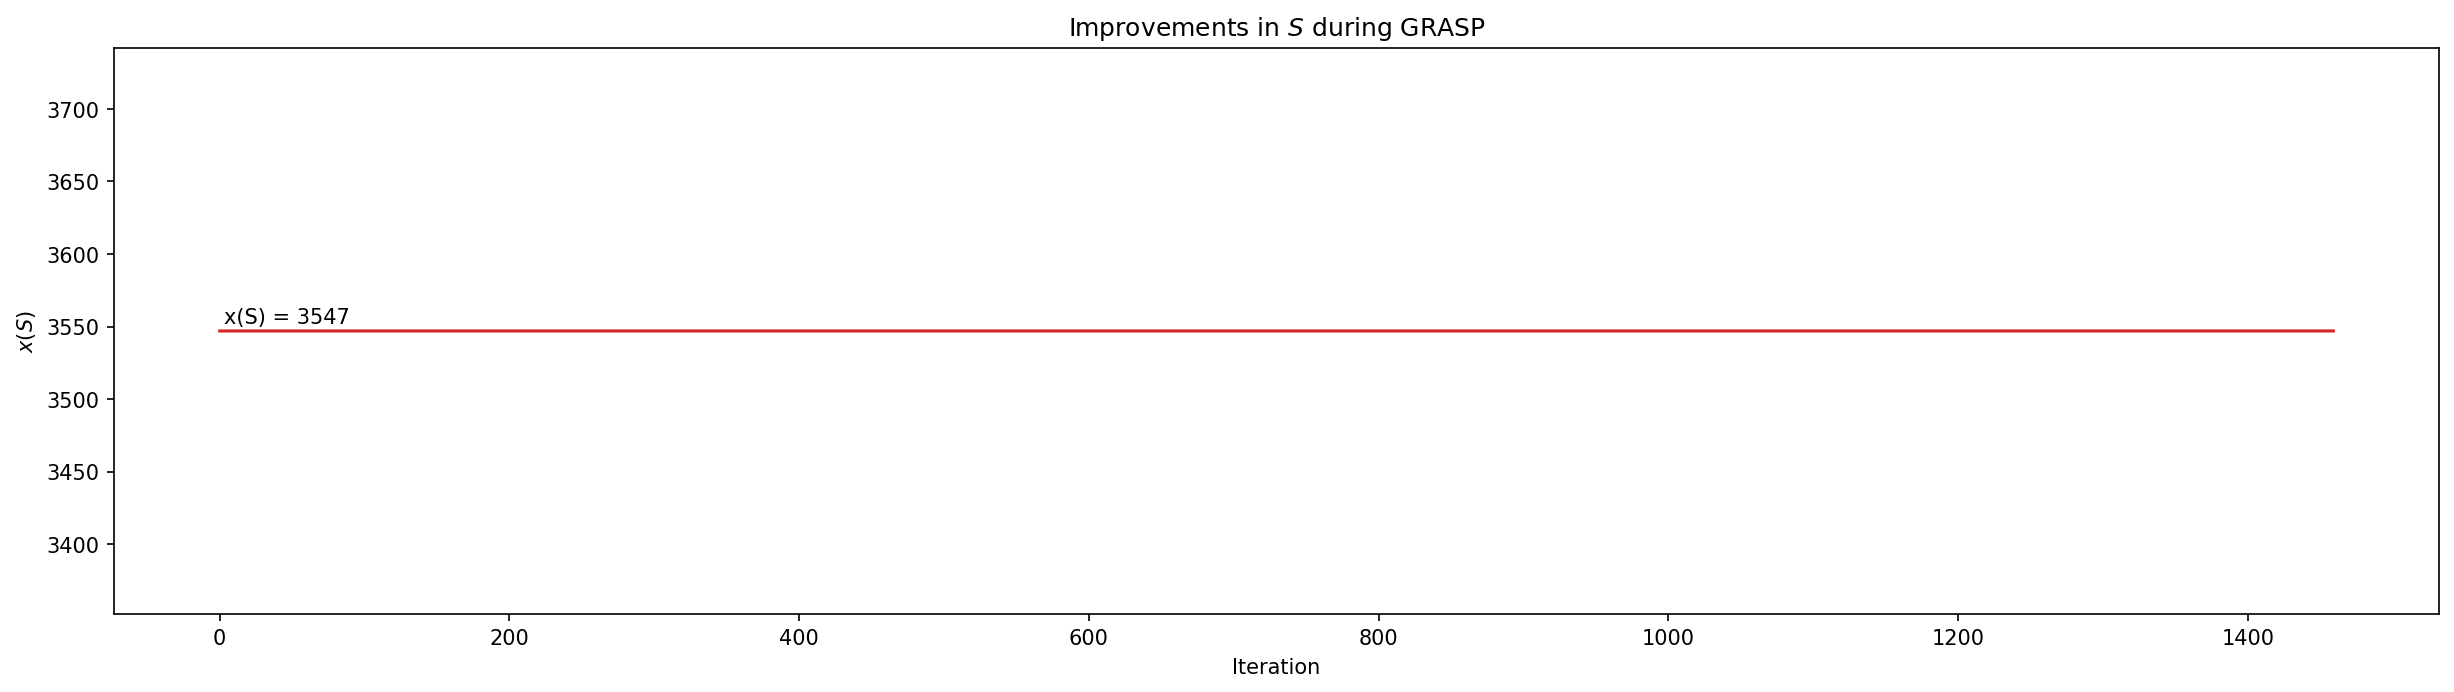

In [14]:
plot_improvs(
    iters, 1460, 3, 5,
    "tab:blue" if name.endswith("2") else "tab:red",
    f"{DIRPATH}\\iters_plot_{name}.png" if save else ""
)